# Multi-Arm Bandits

A one-armed bandit is a slot machine that chooses a random number (positive meaning profit, negative meaning loss) from an internal probability distribution. This probability distribution is unknown to us, but by playing enough with the machine we can make estimates.

In the multi-arm case, we can choose between several one-armed bandit machines, that all have their own internal probability distributions.
If we play with all machines enough, we can find out which machine is the most profitable for us (*exploration*). Afterwards, we mostly play on that machine to try to maximize our profit (*exploitation*).

The difficulty is that we need to find a good trade-off between exploration and exploitation. If the probability distributions of the bandits can change (*nonstationary distributions*), this makes the problem even more difficult.

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt

All one-armed bandits that are simulated here follow normal distributions.

In [ ]:
from random import normalvariate

class ArmedBandit:
    def __init__(self, mean, variance):
        self.mean = mean
        self.variance = variance
        
    def sample(self):
        return normalvariate(self.mean, self.variance)

A bandit ensemble is just a collection of bandits (i.e. a *multi-armed bandit*).

In [ ]:
import numpy as np
from random import random, randint

class BanditEnsemble:
    def __init__(self, num_bandits, Bandit=ArmedBandit):
        self.num_bandits = num_bandits
        self.bandits = []
        
        for i in range(num_bandits):
            mean = random() * 3
            variance = 1
            bandit = Bandit(mean, variance)
            self.bandits.append(bandit)
            
    def sample(self, i):
        return self.bandits[i].sample()
    
    def __len__(self):
        return self.num_bandits
    
    def random_bandit(self):
        return randint(0, self.num_bandits - 1)

The `Game` class evaluates a collection of players and plots their accumulated reward.

In [ ]:
from time import time

class Game:
    def __init__(self, player_generators, Bandit=ArmedBandit):
        self.player_generators = player_generators
        self.Bandit = Bandit
        
    def play(self, num_bandits, num_games, num_iterations):
        t = time()
        
        num_players = len(self.player_generators)
        values = [[0] * num_iterations for _ in range(num_players)]
        
        for _ in range(num_games):
            bandits = BanditEnsemble(num_bandits=num_bandits, Bandit=self.Bandit)    
            players = [gen(bandits) for gen in self.player_generators]
            value = [0] * num_players

            for i in range(num_iterations):
                for j, player in enumerate(players):
                    reward = player.play()
                    val = value[j] + reward
                    values[j][i] += val
                    value[j] = val

        for j, player in enumerate(players):
            label = str(player)
            plt.plot(values[j], label=label)

        plt.legend(loc='upper left')
        plt.xlabel('time units')
        plt.ylabel('accumulated reward')
        plt.title("%d bandits, %d games, %d time units (generated in %.2fsec)" % (num_bandits, num_games, num_iterations, time() - t), y=1.08)
        plt.show()

## $\epsilon$-Greedy Strategy


The `EpsilonGreedyPlayer` chooses the bandit that we currently consider to be the best with a probability of $1 - \epsilon$, and a random bandit otherwise. Ties are broken using a random choice.

In [ ]:
class EpsilonGreedyPlayer:
    def __init__(self, bandits, epsilon, initial=0):
        self.bandits = bandits
        self.epsilon = epsilon
        self.initial = initial
        
        n = len(bandits)
        self.expected = [initial] * n
        self.num_played = [0] * n
        
    def play(self):
        if random() > self.epsilon:
            bandit_i = np.argmax(self.expected)
        else:
            bandit_i = self.bandits.random_bandit()
            
        reward = self.bandits.sample(bandit_i)
        self.num_played[bandit_i] += 1       
        alpha = 1. / self.num_played[bandit_i]
        
        self._adapt_expected_reward(bandit_i, reward, alpha)
                    
        return reward
    
    def _adapt_expected_reward(self, bandit_i, reward, alpha):
        expected_reward = self.expected[bandit_i]
        self.expected[bandit_i] = expected_reward + alpha * (reward - expected_reward)
    
    def __str__(self):
        return "greedy(epsilon=%.3f, initial=%d)" % (self.epsilon, self.initial)

In the case of $\epsilon = 0$ we always play the first bandit that gave us a positive reward. In the case of $\epsilon = 1$ we always play a random bandit. Of course $\epsilon = 0.1$ is superior to both.

In [ ]:
players = [
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=1),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.1),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.01),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0)
]

game = Game(players)
game.play(num_bandits=10, num_games=200, num_iterations=1000)

## Optimistic Initial Values

In this stationary distribution case, $\epsilon$ is not really necessary if we take some time to explore all bandits in the beginning. This can be done by setting the initial expected reward for each bandit to a high positive value (like $20$). This makes us explore all bandits until the expected rewards adapt more to their true values.

As we can see this works very well here.

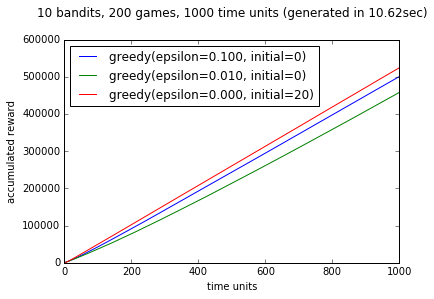

In [179]:
players = [
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.1),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.01),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0, initial=20)
]

game = Game(players)
game.play(num_bandits=10, num_games=200, num_iterations=1000)

## Nonstationary Distributions

In [ ]:
from random import random, normalvariate

class UnreliableArmedBandit:
    def __init__(self, mean, variance):
        self.mean = mean
        self.variance = variance
        
    def sample(self):
        if random() > 0.95:
            self.mean = random() * 10
            self.variance = 1
            
        return normalvariate(self.mean, self.variance)

In [ ]:
players = [
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.1),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0.01),
    lambda bandits: EpsilonGreedyPlayer(bandits, epsilon=0, initial=20)
]

game = Game(players, Bandit=UnreliableArmedBandit)
game.play(num_bandits=10, num_games=50, num_iterations=1000)

## Upper-Confidence-Bound Action Selection

## Gradient Optimization